<a href="https://colab.research.google.com/github/jp2yt/AI-for-medicine/blob/main/Diabetis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Initial Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv('https://raw.githubusercontent.com/jp2yt/AI-for-medicine/main/diabetes.csv')
print(type(df))
df.shape
print(df)
features = list(df.columns)
type(features)
print(features)

<class 'pandas.core.frame.DataFrame'>
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.6

# Visualizing Data Relationships

## Corellation Heatmap

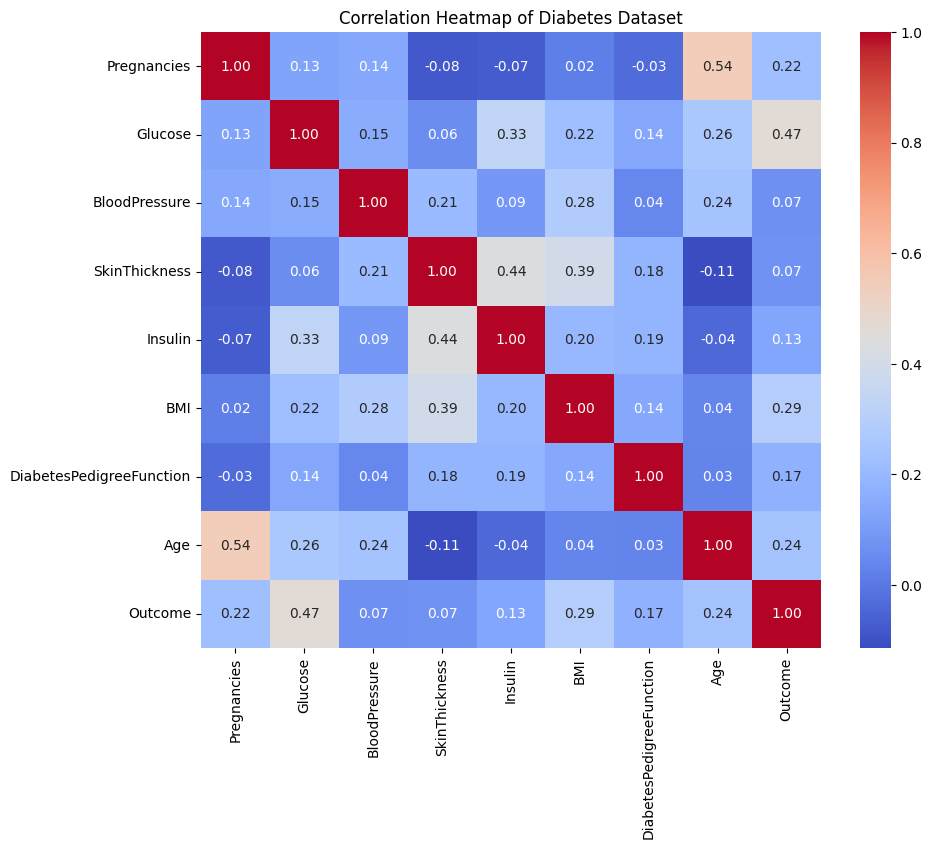

In [2]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Diabetes Dataset")
plt.show()


High correlation (closer to 1 or -1) suggests a strong relationship between features.

For example, Glucose and Outcome often show a strong positive correlation — meaning higher glucose levels are associated with a greater likelihood of diabetes.

## Class Distribution (Outcome)

<ipython-input-4-becc5aaf4f80>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')


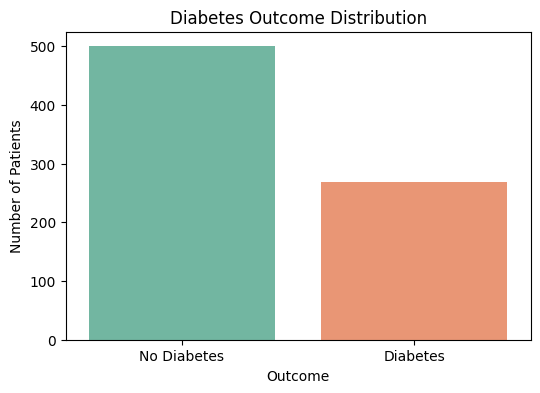

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title("Diabetes Outcome Distribution")
plt.xticks([0, 1], ["No Diabetes", "Diabetes"])
plt.ylabel("Number of Patients")
plt.show()


Useful to check class balance.

If one class dominates (e.g., more non-diabetic than diabetic patients), you may need techniques like balancing the dataset for training ML models.

## Boxplots of Key Features by Outcome

<ipython-input-5-41ed0c5f9d84>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Outcome', y=feature, palette='pastel')
<ipython-input-5-41ed0c5f9d84>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Outcome', y=feature, palette='pastel')
<ipython-input-5-41ed0c5f9d84>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Outcome', y=feature, palette='pastel')
<ipython-input-5-41ed0c5f9d84>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

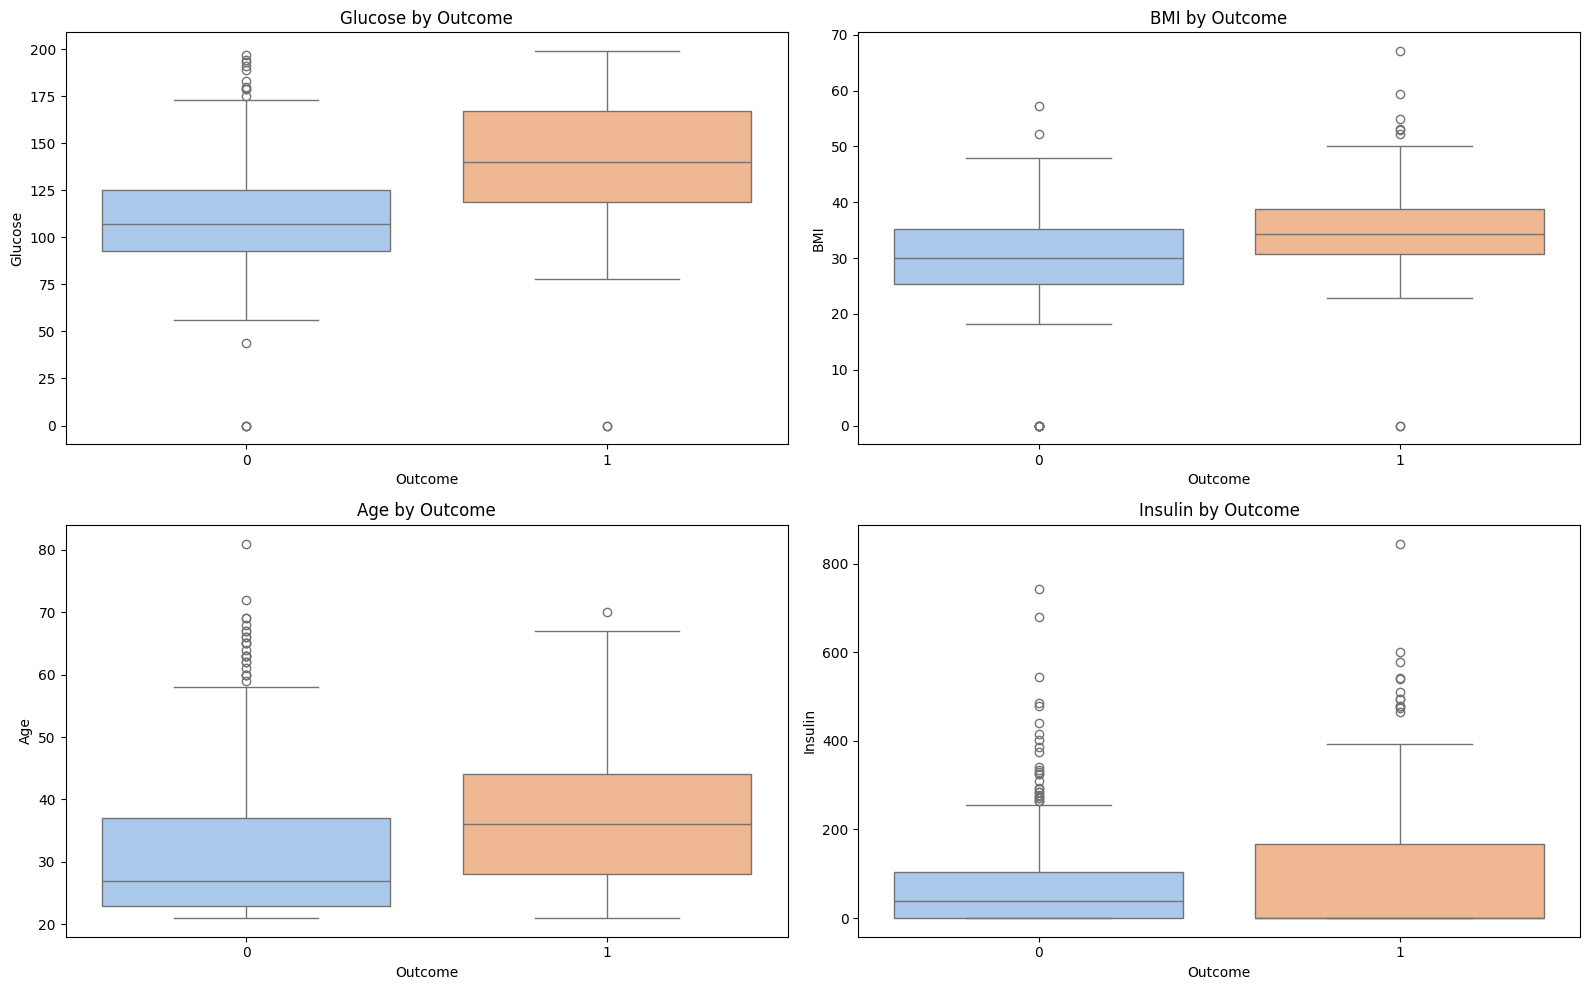

In [5]:
features = ['Glucose', 'BMI', 'Age', 'Insulin']
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='Outcome', y=feature, palette='pastel')
    plt.title(f'{feature} by Outcome')
plt.tight_layout()
plt.show()


Boxplots show median, quartiles, and outliers.

For example, people with diabetes usually have higher glucose and BMI values compared to non-diabetics.

## Scatter Plots: Feature Interactions

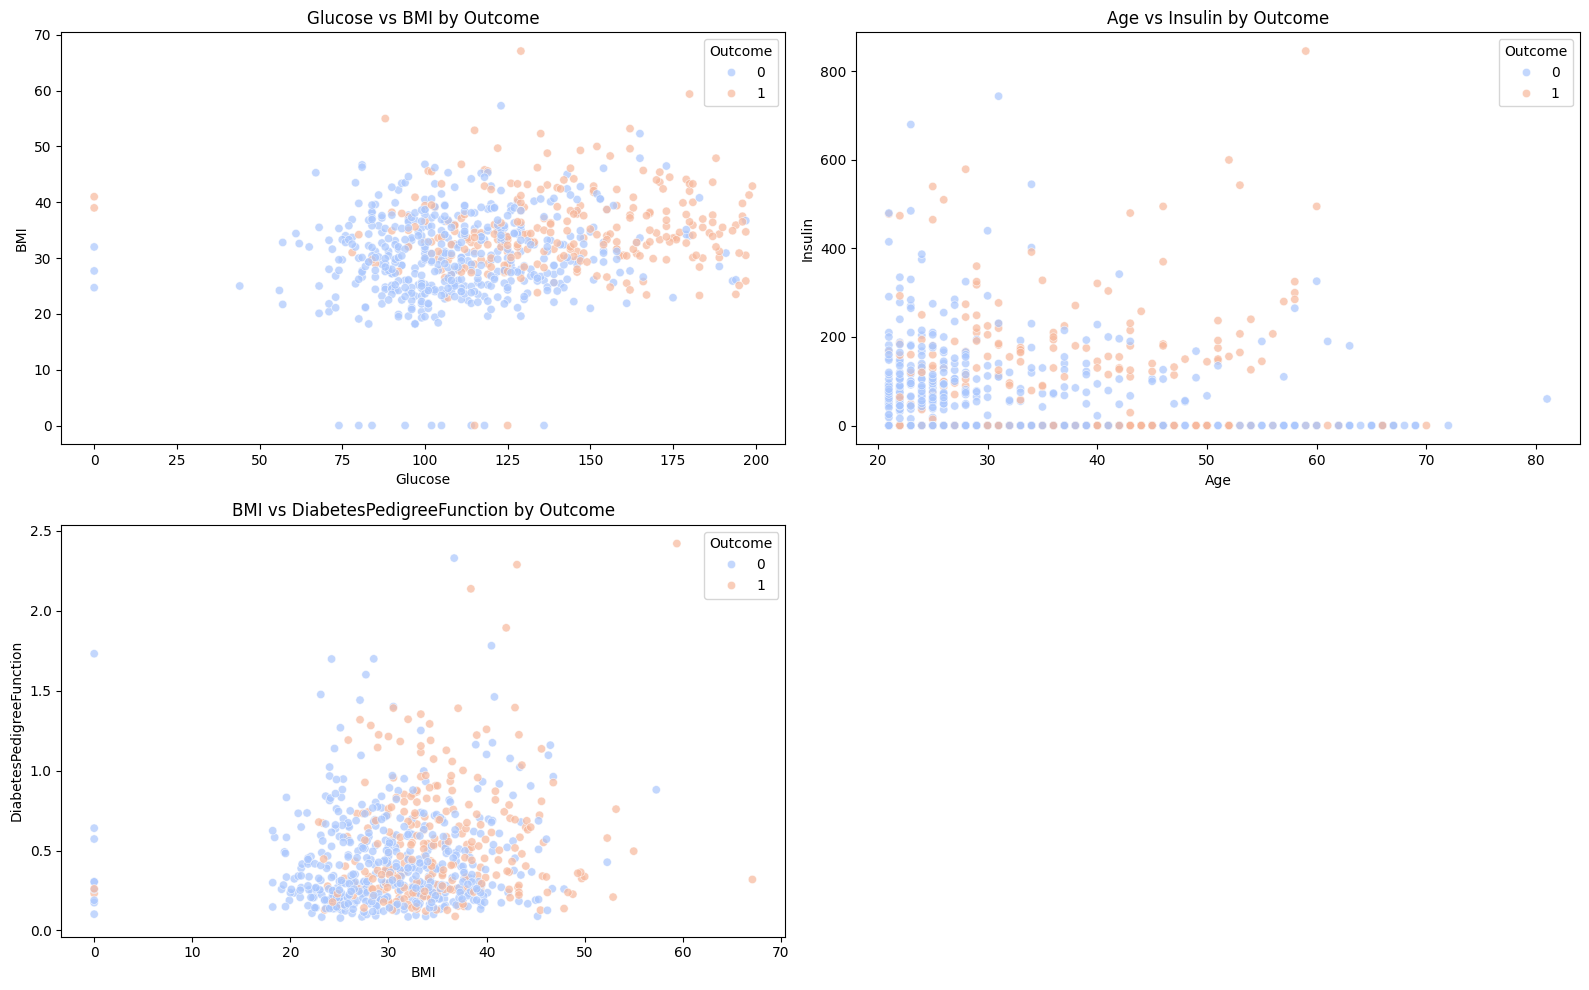

In [6]:
plt.figure(figsize=(16, 10))
pairs = [('Glucose', 'BMI'), ('Age', 'Insulin'), ('BMI', 'DiabetesPedigreeFunction')]
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=x, y=y, hue='Outcome', alpha=0.7, palette='coolwarm')
    plt.title(f'{x} vs {y} by Outcome')
plt.tight_layout()
plt.show()


Helps identify if there are clusters or trends that separate diabetics from non-diabetics.

Example: high Glucose + high BMI might indicate a greater chance of diabetes.

In [ ]:
print("Dataframe shape before NaN removal:", df.shape)


Dataframe shape before NaN removal: (768, 9)


# Handling Missing Data

In [7]:
df.dropna(axis=0, how='any', inplace=True)
print("Dataframe shape after NaN removal:", df.shape)

Dataframe shape after NaN removal: (768, 9)


# Preparing Features and Target Variables

In [9]:

X = df.drop('Outcome', axis=1)
y = df['Outcome']



X is the feature matrix (all columns except Outcome).

y is the target vector (Outcome column).

# Setting Up Nested Cross-Validation Pipeline

In [10]:

SEED = 42
outer_n_folds = 5
inner_n_folds = 5

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Hyperparameter Grid and CV Setup

In [11]:

param_grid = {
    'poly__degree': [1, 2, 3],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

inner_cv = KFold(n_splits=inner_n_folds, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=outer_n_folds, shuffle=True, random_state=SEED)

clf_gs = GridSearchCV(pipe, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Perform Nested Cross-Validation

In [12]:

nested_scores = cross_validate(clf_gs, X, y, cv=outer_cv,
                               return_train_score=True,
                               return_estimator=True,
                               scoring='accuracy')

print("Average Train Accuracy:", np.mean(nested_scores['train_score']))
print("Average Test Accuracy:", np.mean(nested_scores['test_score']))

Average Train Accuracy: 0.7867731257117132
Average Test Accuracy: 0.7630167218402513


# Plot ROC Curves for Each Outer Fold

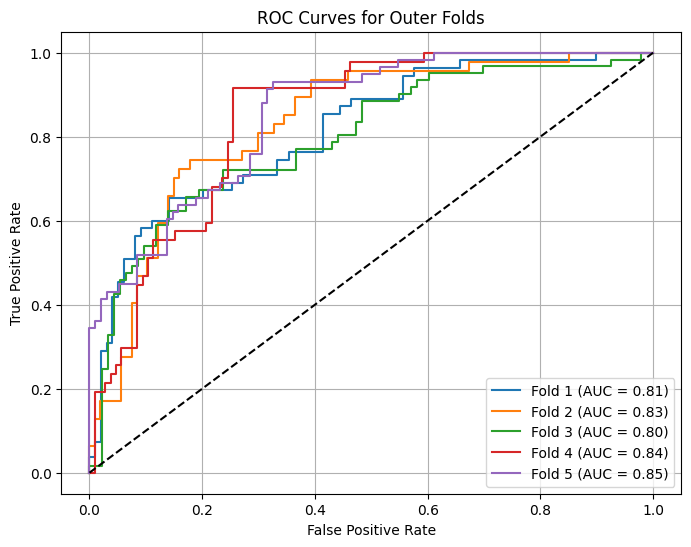

In [13]:
outer_cv = KFold(n_splits=outer_n_folds, shuffle=True, random_state=SEED)

plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    estimator = nested_scores['estimator'][i]

    y_proba = estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Outer Folds')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Visualization of the Decision Boundary

Selected features for visualization: ['Glucose', 'BMI']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


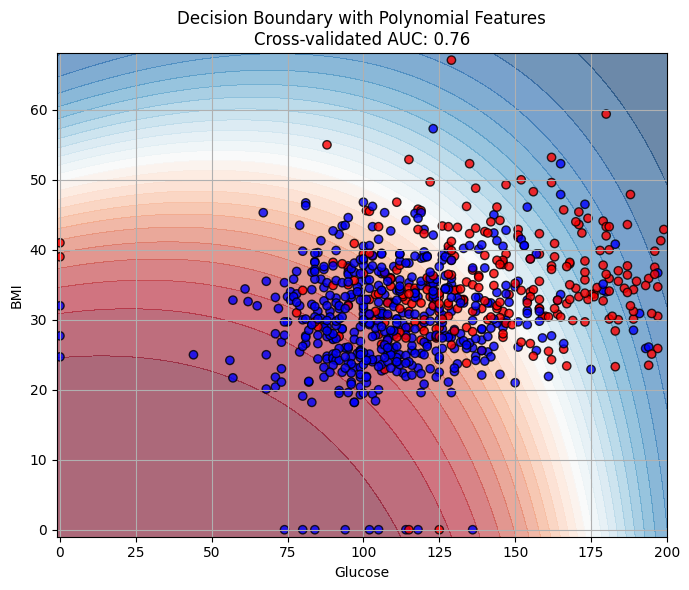

In [14]:
# --- Now select the top 2 features by importance from the best estimator ---

# Extract best estimator from the last fold (or choose the best overall)
best_estimator = nested_scores['estimator'][-1].best_estimator_

# LogisticRegression coef_ after polynomial features can be complicated,
# so instead let's select top 2 features by univariate importance on original X

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=2)
selector.fit(X, y)
best_features_mask = selector.get_support()
best_features = X.columns[best_features_mask]

print("Selected features for visualization:", list(best_features))

# Prepare data for visualization
X_vis = X[best_features]
y_vis = y

pipe_vis = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_estimator.named_steps['poly'].degree, include_bias=False)),
    ('clf', LogisticRegression(
        max_iter=1000,
        C=best_estimator.named_steps['clf'].C,
        penalty='l2',
        solver='lbfgs'))
])

pipe_vis.fit(X_vis, y_vis)

x_min, x_max = X_vis.iloc[:, 0].min() - 1, X_vis.iloc[:, 0].max() + 1
y_min, y_max = X_vis.iloc[:, 1].min() - 1, X_vis.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

X_grid = np.c_[xx.ravel(), yy.ravel()]
Z = pipe_vis.predict_proba(X_grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, levels=25, cmap="RdBu", alpha=0.6)
plt.scatter(X_vis.iloc[:, 0], X_vis.iloc[:, 1], c=y_vis, cmap="bwr", edgecolor="k", alpha=0.8)
plt.title(f"Decision Boundary with Polynomial Features\nCross-validated AUC: {np.mean(nested_scores['test_score']):.2f}")
plt.xlabel(best_features[0])
plt.ylabel(best_features[1])
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning curve

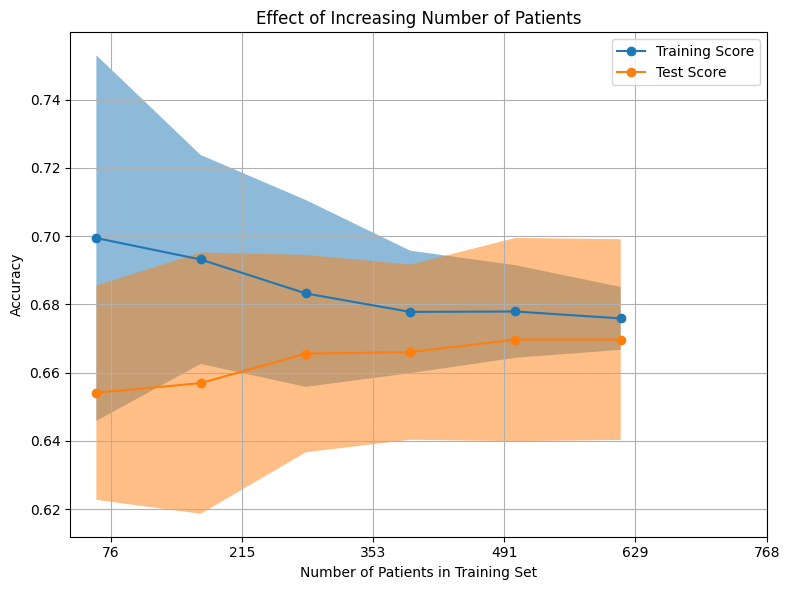

In [15]:
X_subset = X[['Age', 'Pregnancies']]
y_subset = y
# Learning curve
train_sizes = np.linspace(0.1, 1.0, 6)
train_sizes_abs = (train_sizes * len(X_subset)).astype(int)

fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(
    estimator=pipe_vis,
    X=X_subset,
    y=y_subset,
    train_sizes=train_sizes,
    cv=ShuffleSplit(n_splits=30, test_size=0.2, random_state=42),
    score_type='both',
    n_jobs=-1,
    ax=ax,
    std_display_style='fill_between',
    line_kw={"marker": "o"},
    score_name="Accuracy"
)

ax.set_title("Effect of Increasing Number of Patients")
ax.set_xlabel("Number of Patients in Training Set")
ax.set_xticks(train_sizes_abs)
ax.set_xticklabels(train_sizes_abs)
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend(["Training Score", "Test Score"])
plt.tight_layout()
plt.show()

# Confusion Matrix

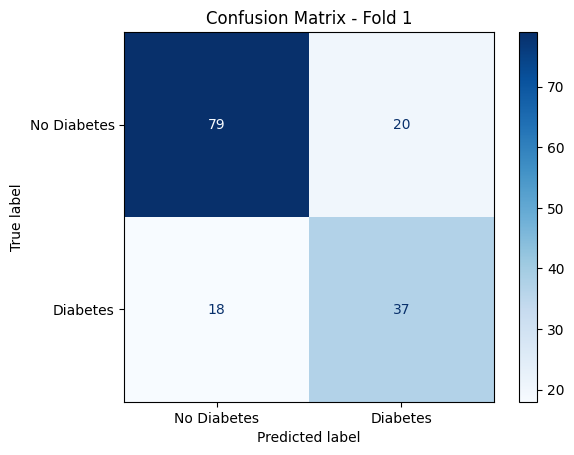

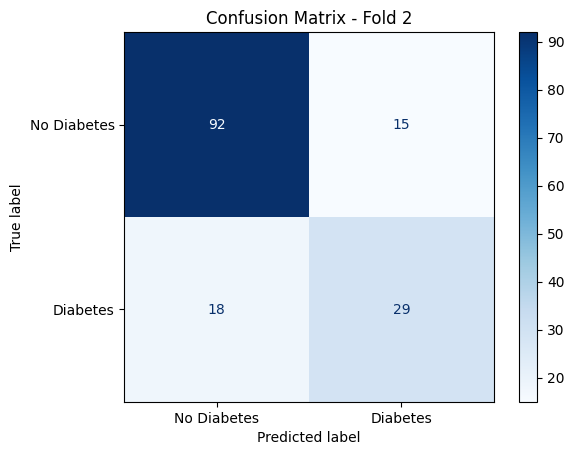

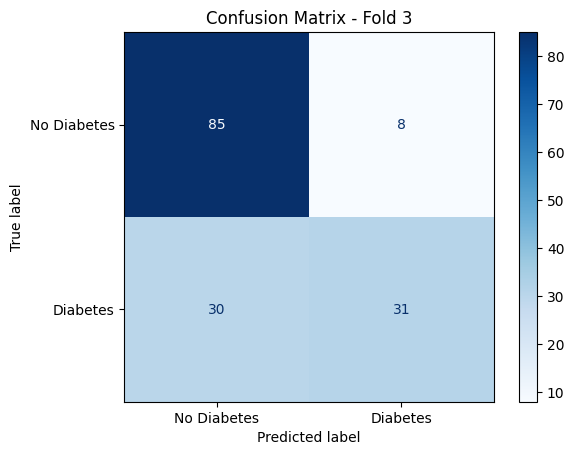

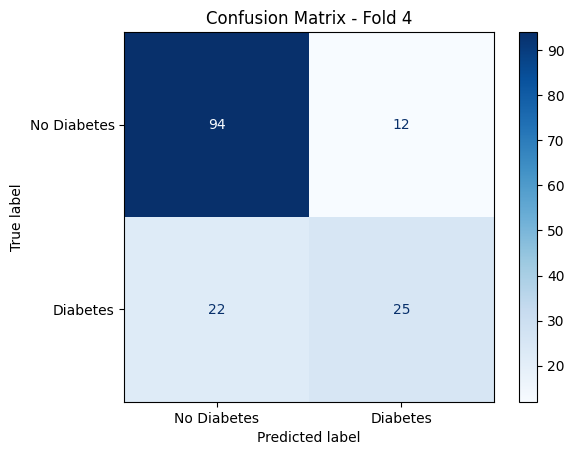

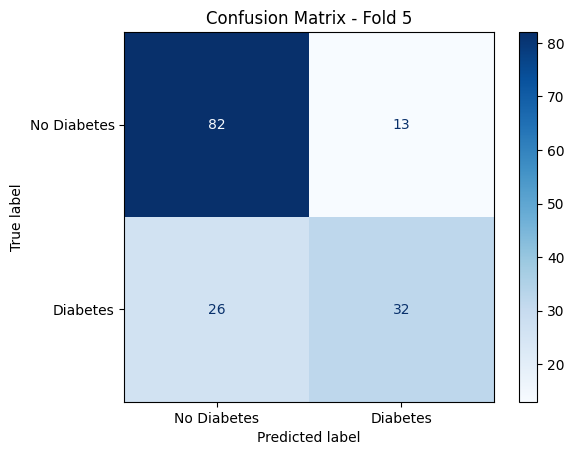

In [16]:
outer_n_folds = 5
SEED = 42
outer_cv = KFold(n_splits=outer_n_folds, shuffle=True, random_state=SEED)

# Generate confusion matrices for each fold
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    estimator = nested_scores['estimator'][i]
    y_pred = estimator.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.show()